# Topic modelling using BERTopic

## Libraries/data required

In [14]:
# IMPORTS
from bertopic import BERTopic
from umap import UMAP
import pandas as pd
import os
from rake_nltk import Rake
from tqdm.notebook import tqdm
import nltk
import yake
from ipywidgets import FloatProgress
from collections import Counter
import itertools
import ast
import re

In [2]:
# Read the data and perform preprocessing
df = pd.read_csv("dataset_with_keywords.csv", parse_dates=["date"]) # Read data into 'df' dataframe
docs = df["summary"].tolist() # Create a list containing all article summaries

## Fitting BERTopic

This might take a while on a CPU. In the background a pre-trained Large Language Model, called the sentence embedder, is used to convert the articles to a semantic vector space. We then perform clustering in this space.

In [3]:
if os.path.exists('southsudan_model'):
    bertopic = BERTopic.load('southsudan_model')
else:
    #Due to the modularity of the model, there is a lot of randomness that hinders reproducibiity of the model.
    #To fight this, you can for example set random state in the dimensionality reduction step via the following lines 
    #or explore a different approach

    umap_model = UMAP(n_neighbors=15, n_components=5, 
                 min_dist=0.0, metric='cosine', random_state=42)
    bertopic = BERTopic(language="english", calculate_probabilities=True, verbose=True, umap_model=umap_model) # Initialize the BERTopic model
    bertopic.fit_transform(docs) # Fit the model to the list of article summaries
    bertopic.save("southsudan_model") # Save the trained model as "southsudan_model"

 # Helper functions

In [4]:
def yake_keyword(dataframe):
    """Applies the yake library to a dataframe. Yake is a library that applies keyword extraction.
    
    Input: 
    - dataframe: A dataframe consisting out of a column with text that needs keyword extraction

    Output:
    - dataframe: Dataframe containing 2 extra columns (paragraph & summary) with the keywords determined by yake.
    
    """
    # Implement a progress bar in the cell to show the progress.
    tqdm.pandas()
    # Apply the keyword extractor function from the NLP library yake.
    language = 'en'
    max_ngram_size = 2
    deduplication_threshold = 0.9
    numOfKeywords = 3  # <- Multiple keywords
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size,
                                                dedupLim=deduplication_threshold,
                                                top=numOfKeywords, features=None)

    extractor = lambda x: custom_kw_extractor.extract_keywords(x)
    # Apply the keyword extraction on both the summaries and the whole article content
    dataframe['paragraphs_3_keywords_2gram_summary'] = dataframe['summary'].progress_apply(extractor)
    dataframe['keywords_paragraphs'] = dataframe['paragraphs'].progress_apply(extractor)
    return

In [5]:
def perform_error_analysis(dataframe, ground_truth_keywords_col):
    """
    Performs error analysis by comparing Yake-extracted keywords with ground-truth keywords.

    Input:
    - dataframe: DataFrame containing Yake-extracted keywords.
    - ground_truth_keywords_col: The column name in the DataFrame containing ground-truth keywords.

    Output:
    - error_summary: DataFrame summarizing error analysis results.
    """
    tqdm.pandas()
    error_data = []

    for idx, row in dataframe.iterrows():
        true_keywords = row[ground_truth_keywords_col]
        yake_summary_keywords = row['keywords_summary']
        yake_content_keywords = row['keywords_paragraphs']
        rake_summary_keywords = row['summary_rake_keywords']
        paragraphs_rake_keywords = row['paragraphs_rake_keywords']

        error_data.append({
            'Document': idx,
            'True Keywords': true_keywords,
            'Yake Keywords (Summary)': yake_summary_keywords,
            'Yake Keywords (Content)': yake_content_keywords,
            'Rake Keywords (Summary)' : rake_summary_keywords,
            'Rake Keywords (Content)' : paragraphs_rake_keywords
        })
        error_summary = pd.DataFrame(error_data)

    return error_summary


In [6]:
df.head(5)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,keywords_summary,keywords_paragraphs,paragraphs_3_keywords_2gram_summary,summary_rake_keywords,paragraphs_rake_keywords
0,0,0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-07,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","[('Sudan', 0.030890419886833533)]","[('Sudan', 0.006790420531629885)]","[('South Sudan', 0.005289617611018771), ('Suda...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ..."
1,1,1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-03,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","[('Sudan', 0.02542656284803938)]","[('South', 0.005956356779761904)]","[('North Sudan', 0.011030950211187246), ('Sout...","['article', 'discusses', 'military', 'actions'...","['logic', 'khartoum', 'military', 'actions', '..."
2,2,2,2,2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-30,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern...","[('Southern', 0.04452588645312403)]","[('Southern', 0.018753573430078812)]","[('Addis Ababa', 0.0039625503330446826), ('Ban...","['article', 'discusses', 'signing', 'framework...","['secretary', 'general', 'ban', 'ki', 'moon', ..."
3,3,3,3,3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-04,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[('Sudan', 0.03705216593247519)]","[('South', 0.007468538638409145)]","[('South Sudan', 0.005189302388800585), ('upco...","['article', 'discusses', 'upcoming', 'independ...","['south', 'sudan', 'readies', 'become', 'world..."
4,4,4,4,4,The article discusses the need for South Sudan...,Juba,The article discusses the need for South Sudan...,2011-07-02,4.859363,31.571250,Juba — The Vice President of the soon-to-be in...,Sudan Tribune,"['South Sudan', 'East Africa', 'Business', 'Ex...","[('order', 0.0737025008366585)]","[('Sudan', 0.00826034811578811)]","[('South Sudan', 0.0162607999296675), ('Act Bi...","['article', 'discusses', 'need', 'south', 'sud...","['juba', '—', 'vice', 'president', 'soon', 'in..."


In [54]:
error_dataframe = perform_error_analysis(df, 'tags')

In [7]:
# Function to extract words between '[' and ','
def extract_words_from_string(keywords_string):
    extracted_words = re.findall(r"'(.*?)'", keywords_string)
    return extracted_words

In [55]:
# Apply the function to the entire column
error_dataframe['Yake Keywords (Summary)'] = error_dataframe['Yake Keywords (Summary)'].apply(extract_words_from_string)
error_dataframe['Yake Keywords (Content)'] = error_dataframe['Yake Keywords (Content)'].apply(extract_words_from_string)
error_dataframe['Rake Keywords (Summary)'] = error_dataframe['Rake Keywords (Summary)'].apply(extract_words_from_string)
error_dataframe['Rake Keywords (Content)'] = error_dataframe['Rake Keywords (Content)'].apply(extract_words_from_string)

In [66]:
# error_dataframe

,Document,True Keywords,Yake Keywords (Summary),Yake Keywords (Content),Rake Keywords (Summary),Rake Keywords (Content)
0,0,"['South Sudan', 'East Africa', 'Governance', '...",[Sudan],[Sudan],"[article, discusses, passing, new, constitutio...","[juba, —, parliament, south, sudan, passed, ne..."
1,1,"['South Sudan', 'East Africa', 'Business', 'Co...",[Sudan],[South],"[article, discusses, military, actions, taken,...","[logic, khartoum, military, actions, abyei, so..."
2,2,"['Sudan', 'East Africa', 'Governance', 'Extern...",[Southern],[Southern],"[article, discusses, signing, framework, agree...","[secretary, general, ban, ki, moon, today, wel..."
3,3,"['Sudan', 'East Africa', 'Africa', 'South Sudan']",[Sudan],[South],"[article, discusses, upcoming, independence, s...","[south, sudan, readies, become, world, younges..."
4,4,"['South Sudan', 'East Africa', 'Business', 'Ex...",[order],[Sudan],"[article, discusses, need, south, sudan, attra...","[juba, —, vice, president, soon, independent, ..."
...,...,...,...,...,...,...
18501,18501,"['Aid and Assistance', 'East Africa', 'South S...",[Sudan],[Annet],"[article, discusses, successful, delivery, twi...","[grace, arrived, maiwut, primary, health, care..."
18502,18502,"['South Sudan', 'East Africa', 'Conflict', 'He...",[Khartoum],[medical],"[article, discusses, bombing, forced, evacuati...","[date, 86, major, essential, hospitals, kharto..."
18503,18503,"['Ethiopia', 'East Africa', 'Governance', 'Con...",[Sudan],[peace],"[article, discusses, prime, minister, abiy, ah...","[addis, ababa, —, prime, minister, abiy, ahmed..."
18504,18504,"['Uganda', 'East Africa', 'Sport', 'Soccer', '...",[South],[Kampala],"[article, discusses, collapse, commercial, bui...","[one, person, killed, sunday, four, others, in..."


In [73]:
# Function to find the intersection between two lists
def find_intersection(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    return list(set1.intersection(set2))

# Apply the function to the DataFrame to find the intersection
error_dataframe['Intersection'] = error_dataframe.apply(lambda row: find_intersection(row['True Keywords'], row['Yake Keywords (Summary)']), axis=1)
error_dataframe[['True Keywords', 'Rake Keywords (Summary)']]

,True Keywords,Rake Keywords (Summary)
0,"['South Sudan', 'East Africa', 'Governance', '...","[article, discusses, passing, new, constitutio..."
1,"['South Sudan', 'East Africa', 'Business', 'Co...","[article, discusses, military, actions, taken,..."
2,"['Sudan', 'East Africa', 'Governance', 'Extern...","[article, discusses, signing, framework, agree..."
3,"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[article, discusses, upcoming, independence, s..."
4,"['South Sudan', 'East Africa', 'Business', 'Ex...","[article, discusses, need, south, sudan, attra..."
...,...,...
18501,"['Aid and Assistance', 'East Africa', 'South S...","[article, discusses, successful, delivery, twi..."
18502,"['South Sudan', 'East Africa', 'Conflict', 'He...","[article, discusses, bombing, forced, evacuati..."
18503,"['Ethiopia', 'East Africa', 'Governance', 'Con...","[article, discusses, prime, minister, abiy, ah..."
18504,"['Uganda', 'East Africa', 'Sport', 'Soccer', '...","[article, discusses, collapse, commercial, bui..."


In [64]:
def calculate_metrics(true_keywords, extracted_keywords):
    true_set = set(true_keywords)
    extracted_set = set(extracted_keywords)
    
    precision = len(true_set.intersection(extracted_set)) / len(extracted_set)
    recall = len(true_set.intersection(extracted_set)) / len(true_set)
    print(precision)
    print(recall)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return precision, recall, f1

In [68]:
# error_dataframe['Yake Precision (Summary)'], error_dataframe['Yake Recall (Summary)'], error_dataframe['Yake F1-Score (Summary)'] = zip(*error_dataframe.apply(lambda row: calculate_metrics(row['True Keywords'], row['Yake Keywords (Summary)']), axis=1))
# # Calculate metrics for Yake (Content)
# error_dataframe['Yake Precision (Content)'], error_dataframe['Yake Recall (Content)'], error_dataframe['Yake F1-Score (Content)'] = zip(*error_dataframe.apply(lambda row: calculate_metrics(row['True Keywords'], row['Yake Keywords (Content)']), axis=1))

# # Calculate metrics for Rake (Summary)
# error_dataframe['Rake Precision (Summary)'], error_dataframe['Rake Recall (Summary)'], error_dataframe['Rake F1-Score (Summary)'] = zip(*error_dataframe.apply(lambda row: calculate_metrics(row['True Keywords'], row['Rake Keywords (Summary)']), axis=1))

# # Calculate metrics for Rake (Content)
error_dataframe['Rake Precision (Content)'], error_dataframe['Rake Recall (Content)'], error_dataframe['Rake F1-Score (Content)'] = zip(*error_dataframe.apply(lambda row: calculate_metrics(row['True Keywords'], row['Rake Keywords (Content)']), axis=1))


0.0
0.0


ZeroDivisionError: float division by zero

In [37]:
def rake_extractor(text):
    """ Determines the keywords."""
    r = Rake()
    nltk.download('stopwords')
    nltk.download('punkt')
    r.extract_keywords_from_text(text)
    return list(r.get_word_degrees().keys())

In [38]:
def rake_keywords(dataframe):
    """Applies the rake library to a dataframe. Rake is a library that applies keyword extraction.
    Input: 
    - dataframe: A dataframe consisting out of a column with text that needs keyword extraction
    Output:
    - dataframe: Dataframe containing 2 extra columns (paragraph & summary) with the keywords determined by rake.
    """
    # Apply the extractor function with a progress bar to the 'summary' column
    tqdm.pandas(desc="Extracting Keywords from 'summary'")
    dataframe['summary_rake_keywords'] = dataframe['summary'].progress_apply(rake_extractor)

    # Apply the extractor function with a progress bar to the 'paragraphs' column
    tqdm.pandas(desc="Extracting Keywords from 'paragraphs'")
    dataframe['paragraphs_rake_keywords'] = dataframe['paragraphs'].progress_apply(rake_extractor)
    return

In [15]:
# We create a function to calculate a list of the top n topics related to (a) given keyword(s)

def get_relevant_topics(bertopic_model, keywords, top_n):
    '''
    Retrieve a list of the top n number of relevant topics to the provided (list of) keyword(s)
    
    
    Parameters:
        bertopic_model: a (fitted) BERTopic model object
        
        keywords:   a string containing one or multiple keywords to match against,
                    
                    This can also be a list in the form of ['keyword(s)', keyword(s), ...]
                    
                    In this case a maximum of top_n topics will be found per list element 
                    and subsetted to the top_n most relevant topics.
                    
                    !!!
                    Take care that this method only considers the relevancy per inputted keyword(s) 
                    and not the relevancy to the combined list of keywords.
                    
                    In other words, topics that appear in the output might be significantly related to a 
                    particular element in the list of keywords but not so to any other element, 
                    
                    while topics that do not appear in the output might be significantly related to the 
                    combined list of keywords but not much to any of the keyword(s) in particular.
                    !!!
                    
        top_n: an integer indicating the number of desired relevant topics to be retrieved
        
        
        Return: a list of the top_n (or less) topics most relevant to the (list of) provided keyword(s)
    '''
    
    if type(keywords) is str: keywords = [keywords] # If a single string is provided convert it to list type
    
    relevant_topics = list() # Initilize an empty list of relevant topics
    
    for keyword in keywords: # Iterate through list of keywords
        
        # Find the top n number of topics related to the current keyword(s)
        topics = bertopic_model.find_topics(keyword, top_n = top_n)
        
        # Add the topics to the list of relevant topics in the form of (topic_id, relevancy)
        relevant_topics.extend(
            zip(topics[0], topics[1]) # topics[0] = topic_id, topics[1] = relevancy
        )
    
    
    relevant_topics.sort(key=lambda x: x[1]) # Sort the list of topics on ASCENDING ORDER of relevancy
    
    # Get a list of the set of unique topics (with greates relevancy in case of duplicate topics)
    relevant_topics = list(dict(relevant_topics).items())
    
    
    relevant_topics.sort(key=lambda x: x[1], reverse=True) # Now sort the list of topics on DESCENDING ORDER of relevancy
    
    return relevant_topics[:10] # Return a list of the top_n unique relevant topics

In [ ]:
# Apply rake and yake to a dataframe and store it.

# df = rake_keywords(df)
# df = yake_keyword(df)
# df.to_csv('dataset_with_keywords.csv')

# Run from here if dataset already contains keywords from yake and rake!
## Determination of keywords

Top Rake keywords with the summarized articles

In [8]:
# --------------- You can only run this line once after you initialized df as the dataframe. --------------
df['summary_rake_keywords'] = df['summary_rake_keywords'].apply(ast.literal_eval)
# ----------------------------------------------------------------------------------------------------------

# Iterate through the DataFrame and print each item in the lists
keywords_list = []
for index, row in df.iterrows():
    for item in row['summary_rake_keywords']:
        keywords_list.append(item)

# Count the keywords and sort them using the Counter library
counts = Counter(keywords_list)

# Create a dataframe to sort the keywords more easily
keywords_rake_summary = pd.DataFrame.from_dict(counts, orient='index').reset_index()
keywords_rake_summary.rename( columns={0 :'values'}, inplace=True )
keywords_rake_summary.sort_values(by='values', ascending=False)

,index,values
0,article,18500
1,discusses,18499
6,south,16898
7,sudan,16534
151,government,6593
...,...,...
16888,sympathize,1
16889,predictions,1
16891,destabilized,1
16895,furthering,1


Top rake keywords with the paragraphs from the articles

In [9]:
# RAKE paragraphs
# Iterate through the DataFrame and print each item in the lists

# --------------- You can only run this line once after you initialized df as the dataframe. --------------
df['paragraphs_rake_keywords'] = df['paragraphs_rake_keywords'].apply(ast.literal_eval)
# ----------------------------------------------------------------------------------------------------------

keywords_list = []
for index, row in df.iterrows():
    for item in row['paragraphs_rake_keywords']:
        keywords_list.append(item)

# Count the keywords and sort them using the Counter library
counts = Counter(keywords_list)

# Create a dataframe to sort the keywords more easily
keywords_rake_paragraphs = pd.DataFrame.from_dict(counts, orient='index').reset_index()
keywords_rake_paragraphs.rename( columns={0 :'values'}, inplace=True )
keywords_rake_paragraphs.sort_values(by='values', ascending=False)

,index,values
4,sudan,17924
3,south,17761
15,said,13722
80,government,12767
51,people,12279
...,...,...
46939,faroqu,1
46937,martials,1
46934,marbles,1
13776,esheraya,1


Top yake keywords from the summary and paragraphs

In [10]:
# Add new columns to the dataframe of the keyword determination with YAKE
df_keywords_summary = pd.DataFrame(df['keywords_summary'])
df_keywords_paragraph = pd.DataFrame(df['keywords_paragraphs'])

# YAKE summary
df_keywords_summary['Extracted_Words'] = df_keywords_summary['keywords_summary'].apply(lambda x: re.search(r'[A-Z][a-z]+', x).group() if re.search(r'[A-Z][a-z]+', x) else "")
df_keywords_summary = pd.DataFrame.from_dict(df_keywords_summary[['Extracted_Words']].value_counts().to_dict(), orient='index').reset_index()
df_keywords_summary.rename(columns={0 :'values'}, inplace=True )

# YAKE paragraphs
# Create a dataframe to sort the keywords more easily
df_keywords_paragraph['Extracted_Words'] = df_keywords_paragraph['keywords_paragraphs'].apply(lambda x: re.search(r'[A-Z][a-z]+', x).group() if re.search(r'[A-Z][a-z]+', x) else "")
df_keywords_paragraph = pd.DataFrame.from_dict(df_keywords_paragraph[['Extracted_Words']].value_counts().to_dict(), orient='index').reset_index()
df_keywords_paragraph.rename(columns={0 :'values'}, inplace=True)

In [47]:
df = pd.read_csv('output_model_LDA.csv')
df.head()
chosen_keywords_lda = []
for i in range(15):  # This will loop from 0 to 14
    column_name = f'Word {i}'  # Construct the column name
    for word in df[column_name]:  # Iterate through the values in the column
        chosen_keywords_lda.append(word)


unique_list = []
for item in chosen_keywords_lda:
    if item not in unique_list:
        unique_list.append(item)

# Now unique_list contains unique elements in the original order
chosen_keywords_lda= set(unique_list)
chosen_keywords_lda

{'abyei',
 'agreement',
 'aid',
 'aim',
 'area',
 'argue',
 'armed',
 'army',
 'assistance',
 'attack',
 'author',
 'border',
 'cattle',
 'challenge',
 'child',
 'civilian',
 'community',
 'conflict',
 'corruption',
 'country',
 'county',
 'crime',
 'crisis',
 'development',
 'discuss',
 'displace',
 'dispute',
 'economic',
 'education',
 'end',
 'fighting',
 'food',
 'force',
 'government',
 'governor',
 'group',
 'highlight',
 'hold',
 'human',
 'humanitarian',
 'igad',
 'improve',
 'include',
 'independence',
 'international',
 'investment',
 'issue',
 'lake',
 'leader',
 'medium',
 'meeting',
 'member',
 'military',
 'minister',
 'nation',
 'national',
 'need',
 'officer',
 'official',
 'oil',
 'party',
 'peace',
 'people',
 'plan',
 'police',
 'political',
 'president',
 'process',
 'production',
 'project',
 'provide',
 'public',
 'rebel',
 'refugee',
 'region',
 'report',
 'result',
 'right',
 'school',
 'sector',
 'security',
 'service',
 'south',
 'state',
 'student',
 'sudan'

Based on the the top provided by the cells above, 14 words are chosen for this project.
The keywords are listed here below.

In [67]:
chosen_keywords_yake_summary_pre2015 = ['South', 'Sudan', 'Juba', 'President', 'Sudanese', 'State', 'Jonglei', 'Bor', 'Kiir',
                                'Abyei', 'Republic', 'United', 'African', 'Ethiopia', 'Ababa', 'Machar', 'Bentiu',
                                'Uganda', 'County', 'Malakal', 'Yau', 'Unity', 'Nile', 'Riek', 'Darfur', 'Lakes',
                                'Kenya', 'Security', 'Wau', 'National', 'Rumbek', 'December', 'Khartoum', 'Nuer',
                                'Salva', 'Hon', 'Africa', 'Ghazal', 'East', 'Western', 'Equatoria', 'General',
                                'Pibor', 'Human', 'Minister', 'Ministry', 'Council', 'University', 'China', 
                                 'Bahr']

chosen_keywords_yake_paragraphs_pre2015 = ['South', 'Sudan', 'Sudanese', 'Kiir', 'Nations', 'United', 'Salva', 'President',
                                  'African', 'Ababa', 'state', 'Addis', 'State', 'Nile', 'Liberation', 'Union',
                                  'Riek', 'Machar', 'Jonglei', 'National', 'Security', 'Council', 'Equatoria',
                                  'Upper', 'People', 'Movement', 'Tribune', 'Bahr', 'Minister', 'Juba', 'Unity',
                                  'Abyei', 'International', 'East', 'Yau', 'Lakes', 'General', 'Africa', 'president',
                                  'Legislative', 'States', 'Mayardit', 'Central', 'County', 'government', 'Western',
                                  'Kordofan', 'Deng', 'Nuer', 'people']
                                  
                                  
chosen_keywords_yake_summary_post2015 = ['South', 'Sudan', 'Juba', 'President', 'Uganda', 'Sudanese', 'Machar',
                                         'African', 'United', 'State', 'Ethiopia', 'Kenya', 'Africa', 'Kiir',
                                         'Khartoum', 'Ababa', 'Minister', 'Unity', 'Rwanda', 'Human', 'Malakal',
                                         'Council', 'Somalia', 'Security', 'East', 'Nile', 'Health', 'Republic',
                                         'Equatoria', 'Abyei', 'June', 'Bentiu', 'County', 'Wau', 'Jonglei', 'Police',
                                         'Darfur', 'July', 'August', 'National', 'Egypt', 'Salva', 'Nigeria', 'Rumbek',
                                         'Kenyan', 'December','November', 'Malong', 'Ugandan', 'Development']

chosen_keywords_yake_paragraphs_post2015 = ['South', 'Sudan', 'Sudanese', 'President', 'Nations', 'United', 'Salva', 'Kiir', 'African', 'Machar',
                                            'Riek', 'Council', 'Security', 'Africa', 'Union', 'State', 'National', 'Minister', 'Nile', 'Addis',
                                            'Liberation', 'Ababa', 'East', 'Foreign', 'Juba', 'government', 'peace', 'States', 'Unity', 'Kenyatta',
                                            'Authority', 'International', 'Affairs', 'People', 'Uganda', 'General', 'Upper', 'Uhuru', 'Prime',
                                            'Development', 'Vice', 'Deputy', 'Movement', 'World', 'state', 'people', 'Transitional', 'Kenya',
                                            'Equatoria', 'Deng']
chosen_keywords_rake_summary_pre2015 = ['south', 'sudan', 'government', 'state', 'president', 'sudanese', 'juba', 'people',
                                        'country', 'conflict', 'peace', 'security', 'kiir', 'including', 'salva', 'international',
                                        'countries', 'oil', 'political', 'un', 'national', 'violence', 'support', 'african', 'forces', 'states',
                                        'new', 'united', 'minister', 'issues', 'ongoing', 'development', 'agreement', 'talks',
                                        'humanitarian', 'machar', 'jonglei', 'unity', 'fighting', 'nile', 'border', 'nations', 'highlights',
                                        'riek', 'civilians', 'khartoum', 'leaders', 'army', 'community', 'former']

chosen_keywords_rake_paragraphs_pre2015 = ['sudan', 'south', 'government', 'people', 'juba', 'country', 'state', 'sudanese', 'president',
                                            'peace', 'kiir', 'security', 'new', 'international', 'salva', 'national', 'states',
                                            'conflict', 'united', 'minister', 'political', 'time', 'countries',
                                            'including', 'support', 'war', 'forces', 'general', 'nations', 'development', 'nation',
                                            'first', 'capital', 'african', 'agreement', 'former', 'fighting', 'world', 'khartoum', 'un',
                                            'community', 'army', 'republic', 'members', 'issues', 'areas', 'independence', 'situation',
                                            'violence', 'splm']
                                            
                                            
chosen_keywords_rake_summary_post2015 = ['south', 'sudan', 'peace', 'government', 'president', 'people', 'country', 'juba', 'sudanese',
                                         'conflict', 'security', 'kiir', 'agreement', 'salva', 'un', 'state', 'war', 'international',
                                         'violence', 'national', 'machar', 'humanitarian', 'million', 'riek', 'countries', 'african',
                                         'political', 'support', 'civil', 'united', 'food', 'uganda', 'unity', 'ongoing', 'leaders',
                                         'states', 'new', 'forces', 'development', 'aid', 'fighting', 'nations', 'vice', 'highlights',
                                         'efforts', 'civilians', 'parties', 'situation', 'crisis', 'council', 'meeting', 'opposition']

chosen_keywords_rake_paragraphs_post2015 = ['sudan', 'south', 'country', 'government', 'people', 'peace', 'president', 'sudanese', 'juba',
                                            'conflict', 'state', 'security', 'kiir', 'war', 'international', 'salva', 'agreement', 'last', 
                                            'national', 'new', 'united', 'machar', 'first', 'riek', 'un', 'countries', 'political', 'african',
                                            'time', 'support', 'million', 'violence', 'nations', 'world', 'according', 'forces', 'civil',
                                            'development', 'fighting', 'end', 'humanitarian', 'former', 'states', 'leaders', 'parties', 'africa',
                                            'minister', 'vice', 'general', 'community']
                                            

chosen_keywords_chatgpt = ["Conflict","Peace","Famine","Politics","Aid","UN","Government","Violence","Refugee","Election","Corruption",
                           "Humanitarian","Economy","Security""Rebel","Independence","Poverty","Oil","Diplomacy","Healthcare","Education",
                           "Militia","Inflation","Crisis","Food","Sanctions","Child","Displacement","Peacekeeping","Resolution","Democracy",
                           "War","Infrastructure","Woman",  "Media",  "Ethnicity",  "Mediation","Coup","Agriculture","Water","Development",
                           "Youth","Judicial","Energy","Childbirth","Conservation","Forest","Mining","Tribes","Injustice"]



In [68]:
chosen_keywords_chatgpt = set([x.lower() for x in chosen_keywords_chatgpt])
chosen_keywords_yake_paragraphs_post2015 = [x.lower() for x in chosen_keywords_yake_paragraphs_post2015]
chosen_keywords_yake_summary_post2015= [x.lower() for x in chosen_keywords_yake_summary_post2015]
chosen_keywords_yake_paragraphs_pre2015= [x.lower() for x in chosen_keywords_yake_paragraphs_pre2015]
chosen_keywords_yake_summary_pre2015= [x.lower() for x in chosen_keywords_yake_summary_pre2015]

In [83]:
all_keywords_yake_pre2015 = chosen_keywords_yake_summary_pre2015 + chosen_keywords_yake_paragraphs_pre2015
all_keywords_yake_post2015 = chosen_keywords_yake_summary_post2015 + chosen_keywords_yake_paragraphs_post2015
all_keywords_rake_pre2015 = chosen_keywords_rake_summary_pre2015 + chosen_keywords_rake_paragraphs_pre2015
all_keywords_rake_post2015 = chosen_keywords_rake_summary_post2015 + chosen_keywords_rake_paragraphs_post2015
all_keywords_rake = all_keywords_rake_post2015 + all_keywords_rake_pre2015
all_keywords_yake = all_keywords_yake_post2015 + all_keywords_yake_pre2015

Text(0.5, 1.0, 'All keywords')

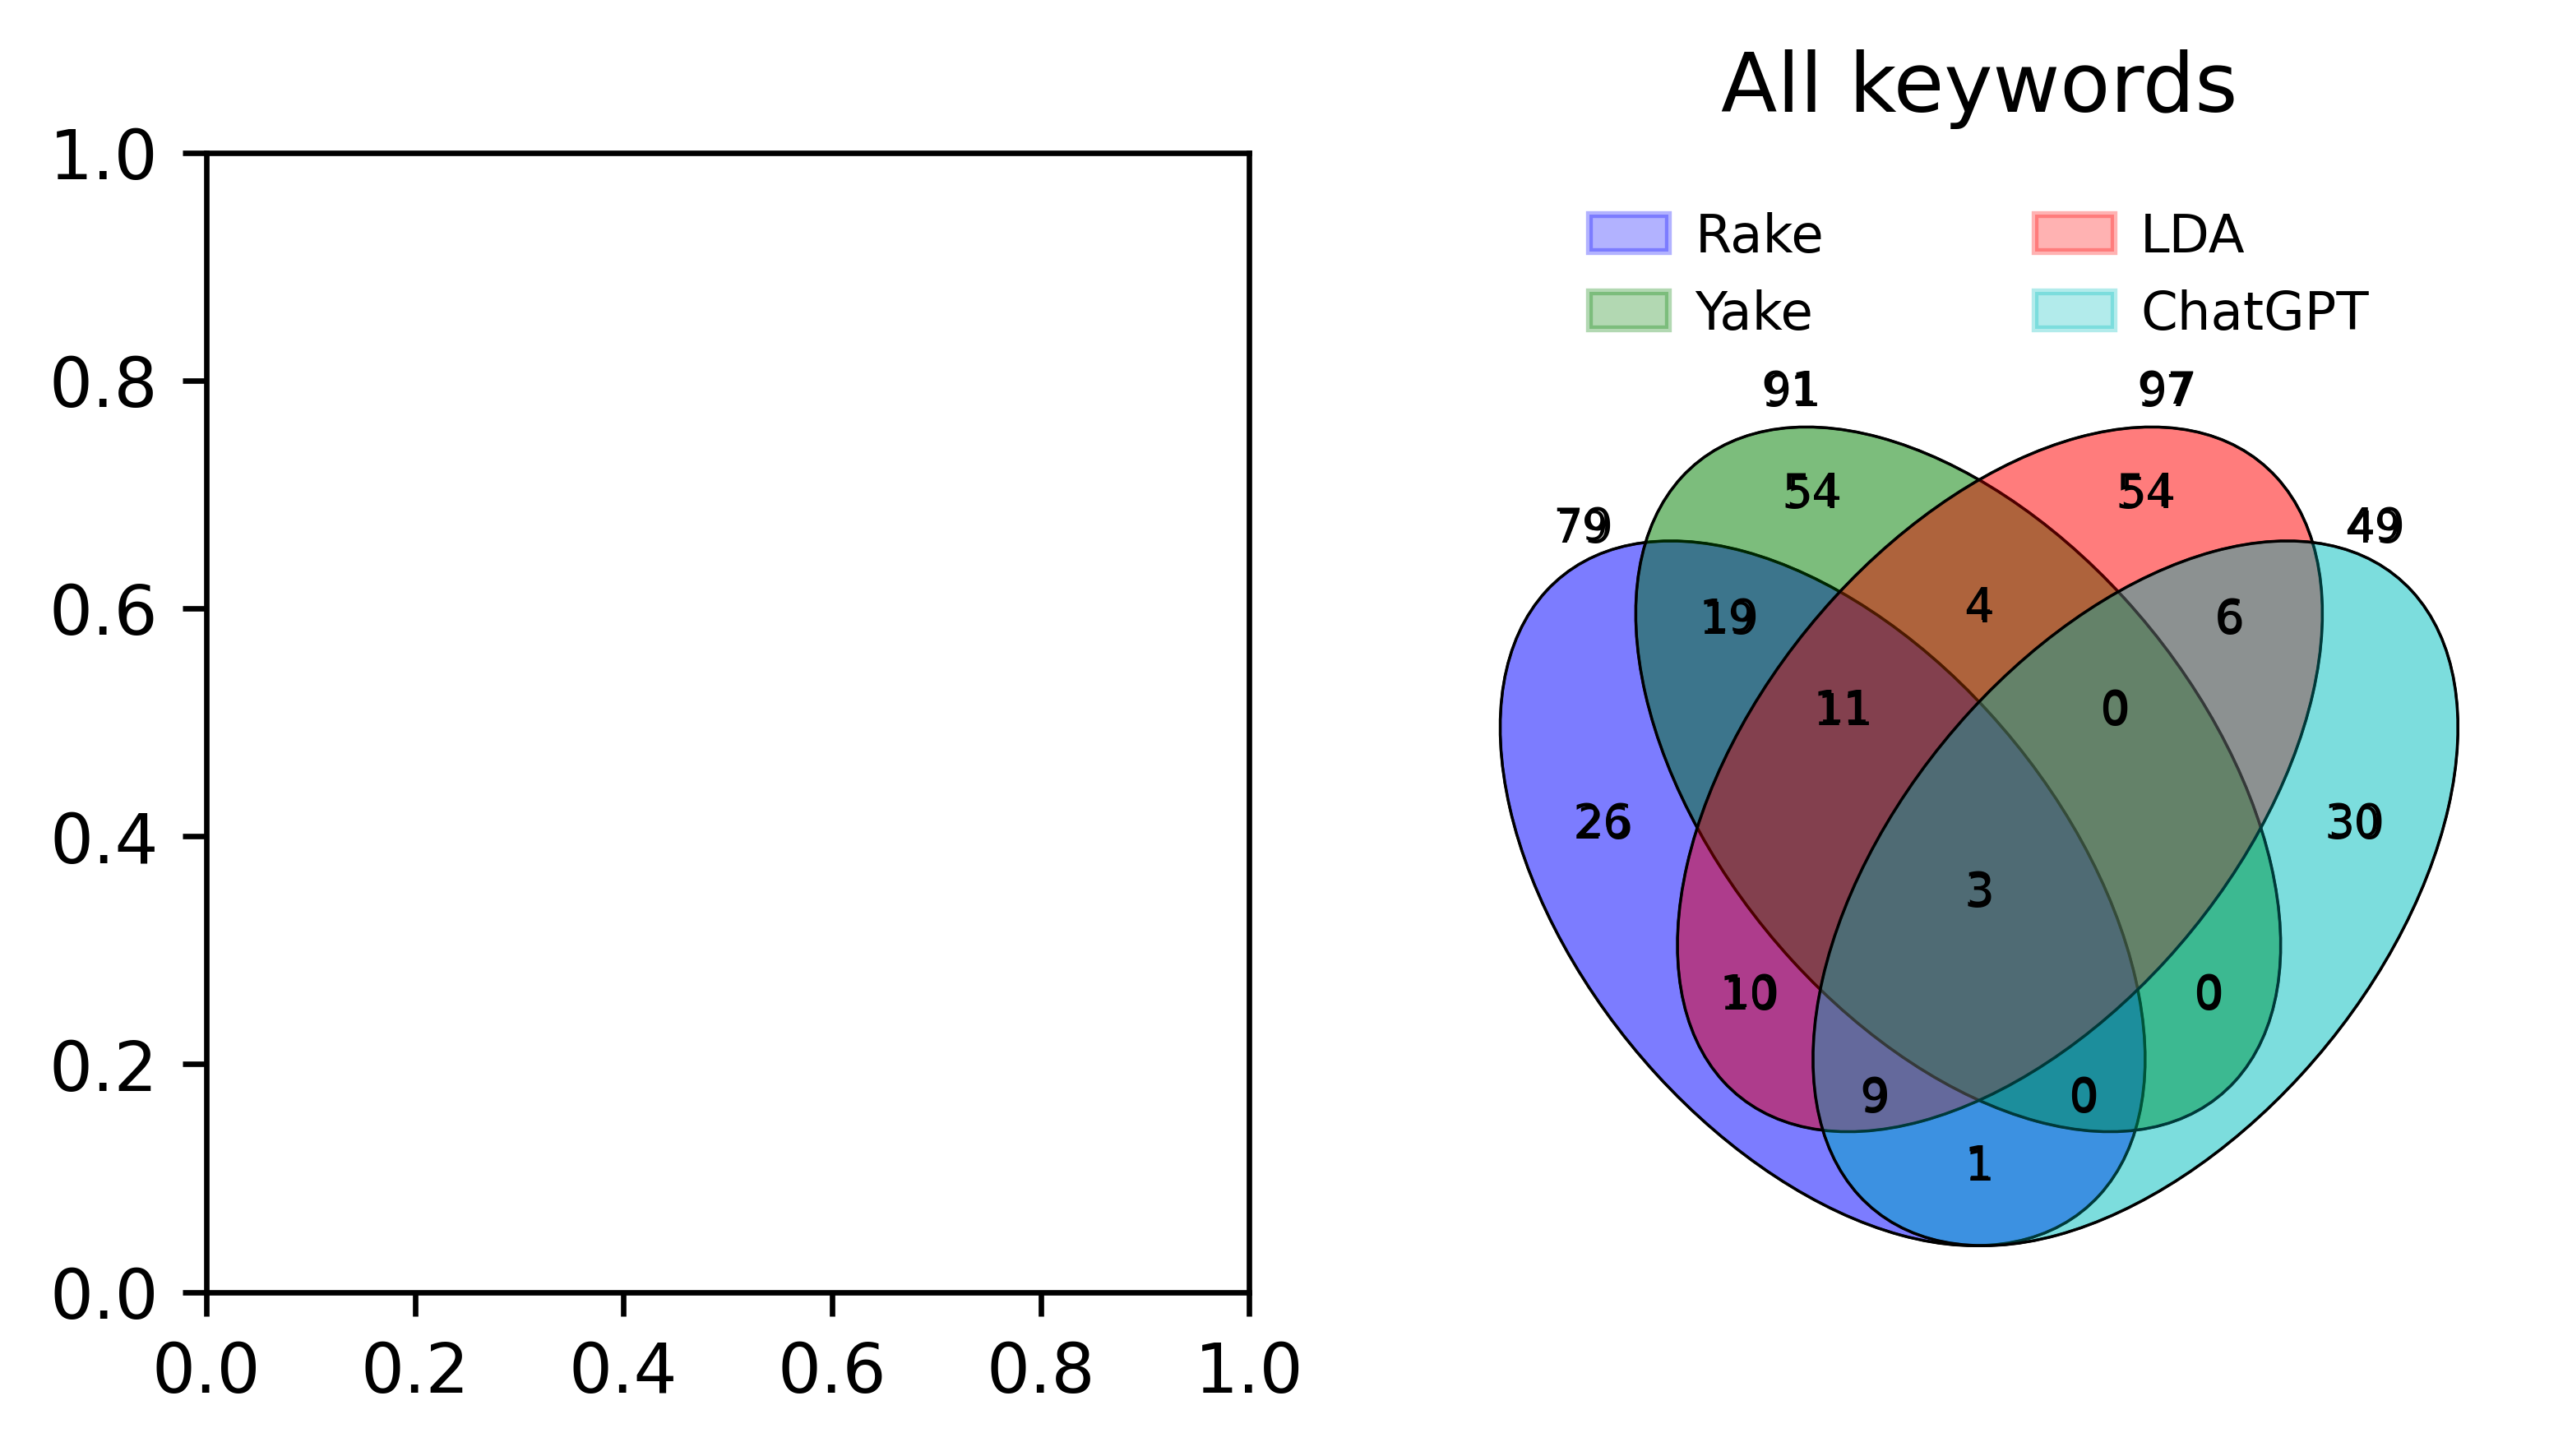

In [84]:
from venny4py.venny4py import *

#dict of sets
sets = {
    'Rake': set(all_keywords_rake),
    'Yake': set(all_keywords_yake),
    'LDA': set(chosen_keywords_lda),
    'ChatGPT': set(chosen_keywords_chatgpt)}
    
from venny4py.venny4py import *
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=600)
ax = axes[1]
venny4py(sets=sets, size=3, asax=ax)
   
venny4py(sets=sets, asax=ax)
ax.set_title('All keywords')

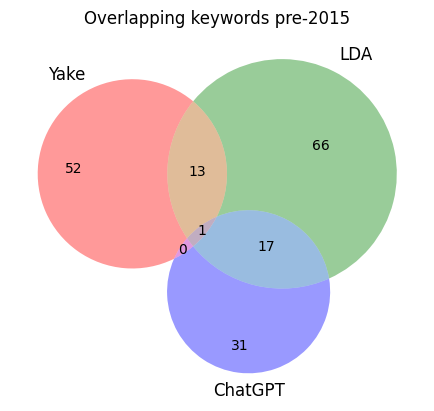

In [71]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Create a Venn diagram
venn3([all_keywords_yake_pre2015, chosen_keywords_lda, chosen_keywords_chatgpt], ('Yake', 'LDA', 'ChatGPT'))

# Display the diagram
plt.title("Overlapping keywords pre-2015")
plt.show()

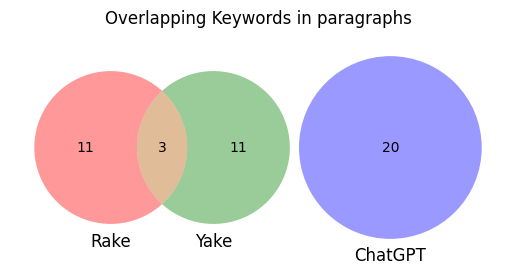

In [15]:
from matplotlib_venn import venn3

# Create a Venn diagram
venn3([chosen_keywords_yake_paragraphs, chosen_keywords_rake_paragraphs, chosen_keywords_chat_gpt], ('Rake', 'Yake', 'ChatGPT'))

# Display the diagram
plt.title("Overlapping Keywords in paragraphs")
plt.show()

In [8]:
def add_keywords_as_columns_to_dataframe(chosen_words_list_all_possibilities, dataframe):
    """Add the keywords generated by key word extraction method as a column to a dataframe 
    with a value containing True or False depending on wheteher the keyword relates to the article.

    Input:
    - chosen_words_list_all_possibilities: list of keywords

    Output:
    - dataframe
    """
    for item in tqdm(chosen_words_list_all_possibilities):
        print(item)
        # Get the top 10 topics related to the keywords 'hunger' and 'food insecurity'
        relevant_topics = get_relevant_topics(bertopic_model = bertopic, keywords=item, top_n=10)

        topic_ids = [el[0] for el in relevant_topics] # Create seperate list of topic IDs

        # for topic_id, relevancy in relevant_topics: # Print neat list of (topic_id, relevancy) tuples
        #     print(topic_id, relevancy)

        item = str([item])   
        dataframe[item] = [t in topic_ids for t in bertopic.topics_] # Add boolean column to df if topic in list of relevant topics

        # View the Count, Name, Representation, and Representative Docs for the relevant topics
        # bertopic.get_topic_info().set_index('Topic').loc[topic_ids]
    return dataframe

# From keywords to dataframe ready for OLS

In [36]:
# Apply the function to the different dataframes
df_rake_paragraphs = add_keywords_as_columns_to_dataframe(chosen_keywords_rake_paragraphs, df_rake_paragraphs)
df_rake_summary = add_keywords_as_columns_to_dataframe(chosen_keywords_rake_summary, df_rake_summary)
df_yake_paragraphs = add_keywords_as_columns_to_dataframe(chosen_keywords_yake_paragraphs, df_yake_paragraphs)
df_yake_summary = add_keywords_as_columns_to_dataframe(chosen_keywords_yake_summary, df_yake_summary)

  0%|          | 0/14 [00:00<?, ?it/s]

government
people
juba
president
state
peace
security
international
conflict
year
national
united
war
political


  0%|          | 0/14 [00:00<?, ?it/s]

government
president
peace
juba
conflict
security
violence
international
un
support
humanitarian
oil
war
machar


  0%|          | 0/14 [00:00<?, ?it/s]

juba
abyei
president
machar
Uganda
jonglei
darfur
nile
minister
nuer
khartoum
government
police
ethiopia


  0%|          | 0/14 [00:00<?, ?it/s]

president
jonglei
uganda
abyei
machar
united
bor
ethiopia
republic
ababa
bentiu
malakal
kenya
unity


In [37]:
df_rake_paragraphs.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'index',
       'name', 'summary', 'date', 'lat', 'lng', 'paragraphs', 'publisher',
       'tags', 'keywords_summary', 'keywords_paragraphs',
       'paragraphs_3_keywords_2gram_summary', 'summary_rake_keywords',
       'paragraphs_rake_keywords', '['government']', '['people']', '['juba']',
       '['president']', '['state']', '['peace']', '['security']',
       '['international']', '['conflict']', '['year']', '['national']',
       '['united']', '['war']', '['political']'],
      dtype='object')

In [38]:
# store the csv's
df_rake_paragraphs.to_csv('df_rake_paragraphs.csv')
df_rake_summary.to_csv('df_rake_summary.csv')
df_yake_paragraphs.to_csv('df_yake_paragraphs.csv')
df_yake_summary.to_csv('df_yake_summary.csv')

### add chatgpt generated keywords

<b>The following Chatgpt interaction was used:</b>

consider the situation of South Sudan. Present 20 singular keywords in a list format that describe the past situation of South Sudan.

ChatGPT

Certainly, here are 20 keywords that describe the past situation of South Sudan:

~

User

The keywords may only consist of a single word. abbreviations of parties are allowed

ChatGPT

Understood, here are 20 single-word keywords and abbreviations that describe the past situation of South Sudan:

~

User

Civil War is not a single word, reconsider the list

ChatGPT

Certainly, here's a revised list of single-word keywords and abbreviations that describe the past situation of South Sudan:

~

User

can you put quotations around the words and a comma in between like a python list format?

ChatGPT

Certainly, here's the list of single-word keywords and abbreviations for the past situation of South Sudan in Python list format:

~

In [ ]:
gpt_keywords = ["Independence", "Secession", "Conflict", "Famine", "Peace", "Refugees", "Ethnicity", "UNMISS", "SPLA", "Oil", "Displacement", "Children", "Referendum", "Instability", "Clashes", "Drought", "Corruption", "Mediation", "Crisis", "Rebel"]
df_gpt = add_keywords_as_columns_to_dataframe(gpt_keywords)
df_gpt.to_csv('df_gpt.csv')

NameError: name 'add_keywords_as_columns_to_dataframe' is not defined